In [17]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [ ]:
img_height = 244
img_width = 244
batch_size = 32


dataset_path = "C:\\Users\\AS\\Desktop\\PROJECT IMPLEMENTATION\\Faulty_solar_panel"

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

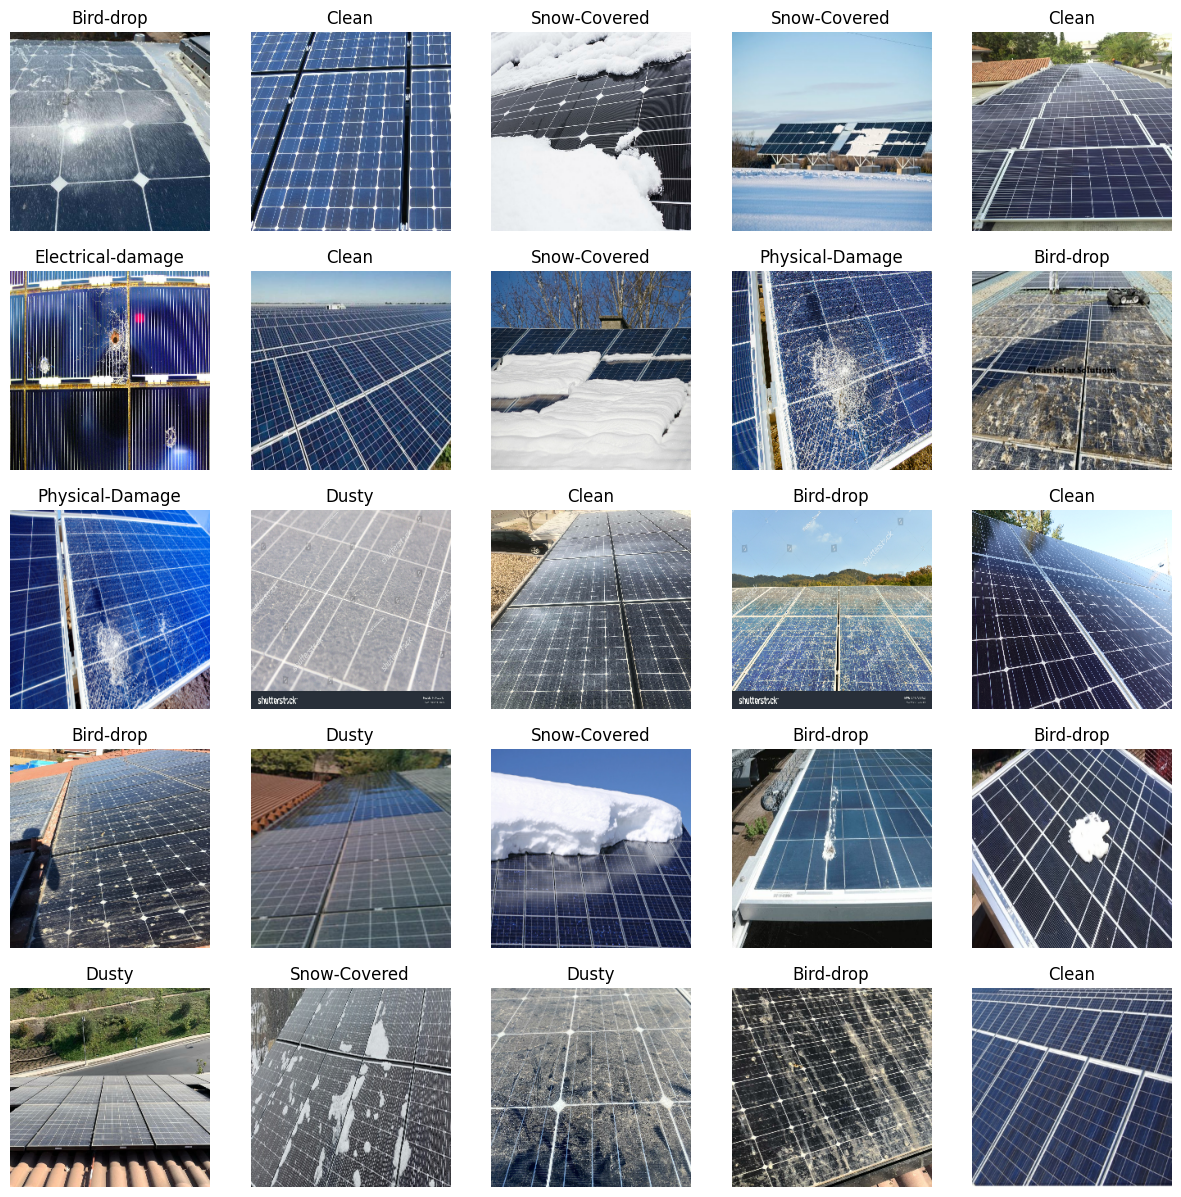

In [5]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

In [7]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 244, 244, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 244, 244, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

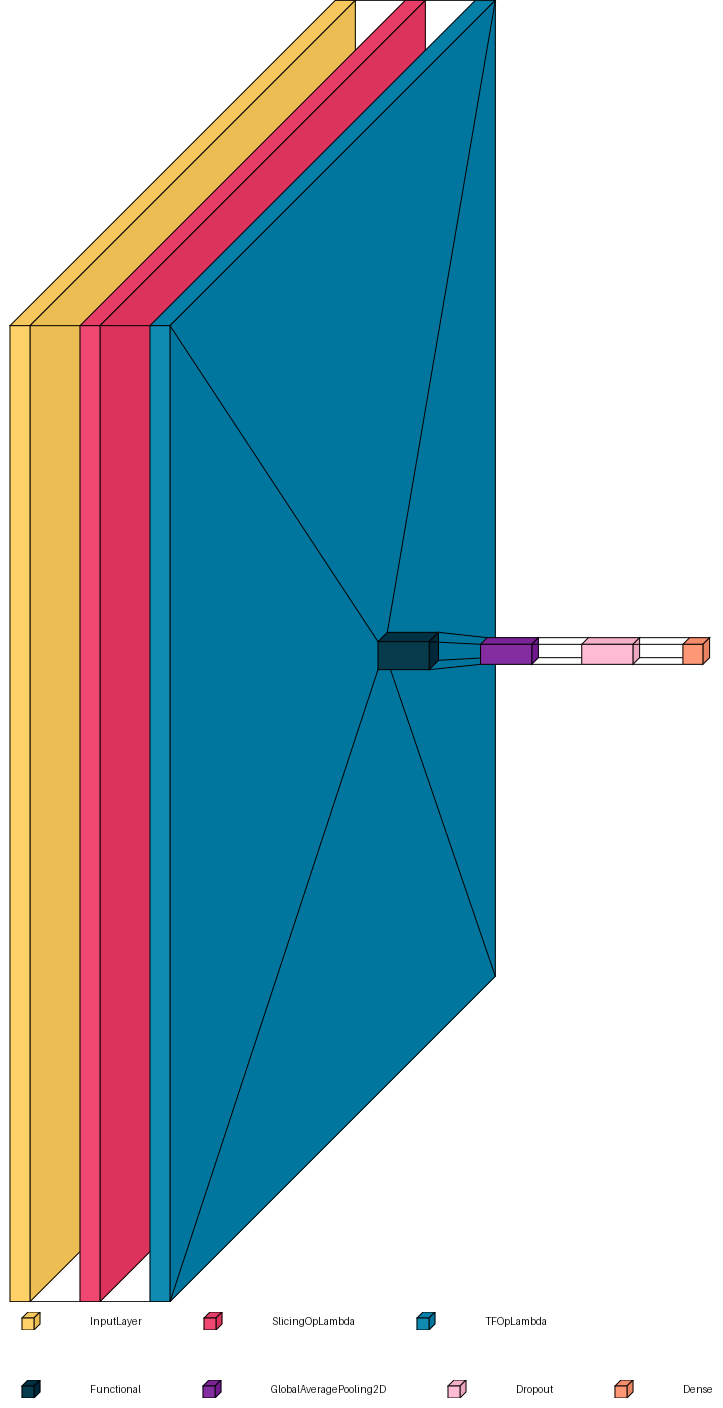

In [8]:
import visualkeras
visualkeras.layered_view(model,legend=True,spacing=50,background_fill = 'white')

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
epoch = 15
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
23/23 [==============================] - 129s 5s/step - loss: 7.7548 - accuracy: 0.1540 - val_loss: 4.8395 - val_accuracy: 0.2260
Epoch 2/15
23/23 [==============================] - 123s 5s/step - loss: 4.8847 - accuracy: 0.2895 - val_loss: 3.2678 - val_accuracy: 0.3672
Epoch 3/15
23/23 [==============================] - 121s 5s/step - loss: 3.4966 - accuracy: 0.3870 - val_loss: 2.5165 - val_accuracy: 0.4576
Epoch 4/15
23/23 [==============================] - 122s 5s/step - loss: 2.6425 - accuracy: 0.4562 - val_loss: 2.1058 - val_accuracy: 0.5311
Epoch 5/15
23/23 [==============================] - 129s 6s/step - loss: 2.3572 - accuracy: 0.5212 - val_loss: 1.8942 - val_accuracy: 0.5593
Epoch 6/15
23/23 [==============================] - 125s 5s/step - loss: 1.8381 - accuracy: 0.6116 - val_loss: 1.6904 - val_accuracy: 0.5876
Epoch 7/15
23/23 [==============================] - 124s 5s/step - loss: 1.6072 - accuracy: 0.6158 - val_loss: 1.6062 - val_accuracy: 0.6102
Epoch 8/15
23

In [11]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 244, 244, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 244, 244, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epoch = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/15
23/23 [==============================] - 151s 6s/step - loss: 0.8666 - accuracy: 0.6977 - val_loss: 0.8296 - val_accuracy: 0.7514
Epoch 2/15
23/23 [==============================] - 152s 7s/step - loss: 0.4252 - accuracy: 0.8602 - val_loss: 0.7875 - val_accuracy: 0.7627
Epoch 3/15
23/23 [==============================] - 160s 7s/step - loss: 0.2364 - accuracy: 0.9322 - val_loss: 0.7019 - val_accuracy: 0.8249
Epoch 4/15
23/23 [==============================] - 151s 7s/step - loss: 0.1194 - accuracy: 0.9562 - val_loss: 0.8884 - val_accuracy: 0.7797
Epoch 5/15
23/23 [==============================] - 151s 7s/step - loss: 0.1028 - accuracy: 0.9718 - val_loss: 0.8965 - val_accuracy: 0.8023
Epoch 6/15
23/23 [==============================] - 153s 7s/step - loss: 0.0680 - accuracy: 0.9760 - val_loss: 0.8576 - val_accuracy: 0.8023
Epoch 6: early stopping


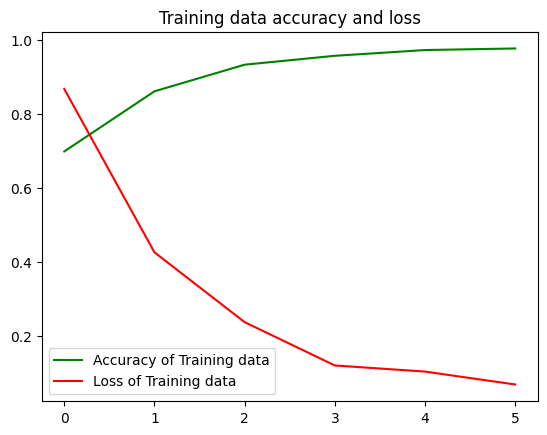

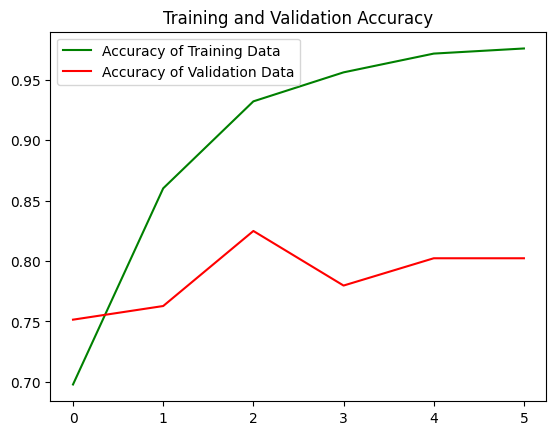

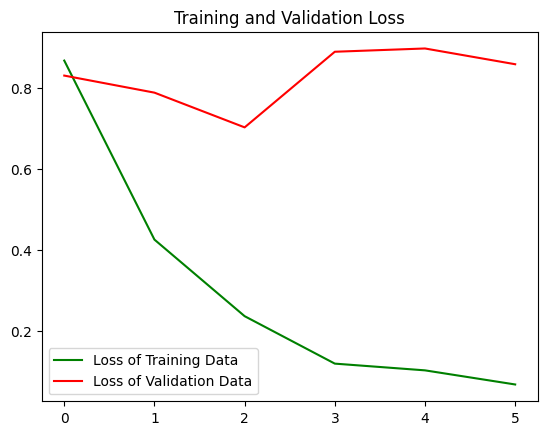

<Figure size 640x480 with 0 Axes>

In [14]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

1/1 [==============================] - 0s 252ms/step


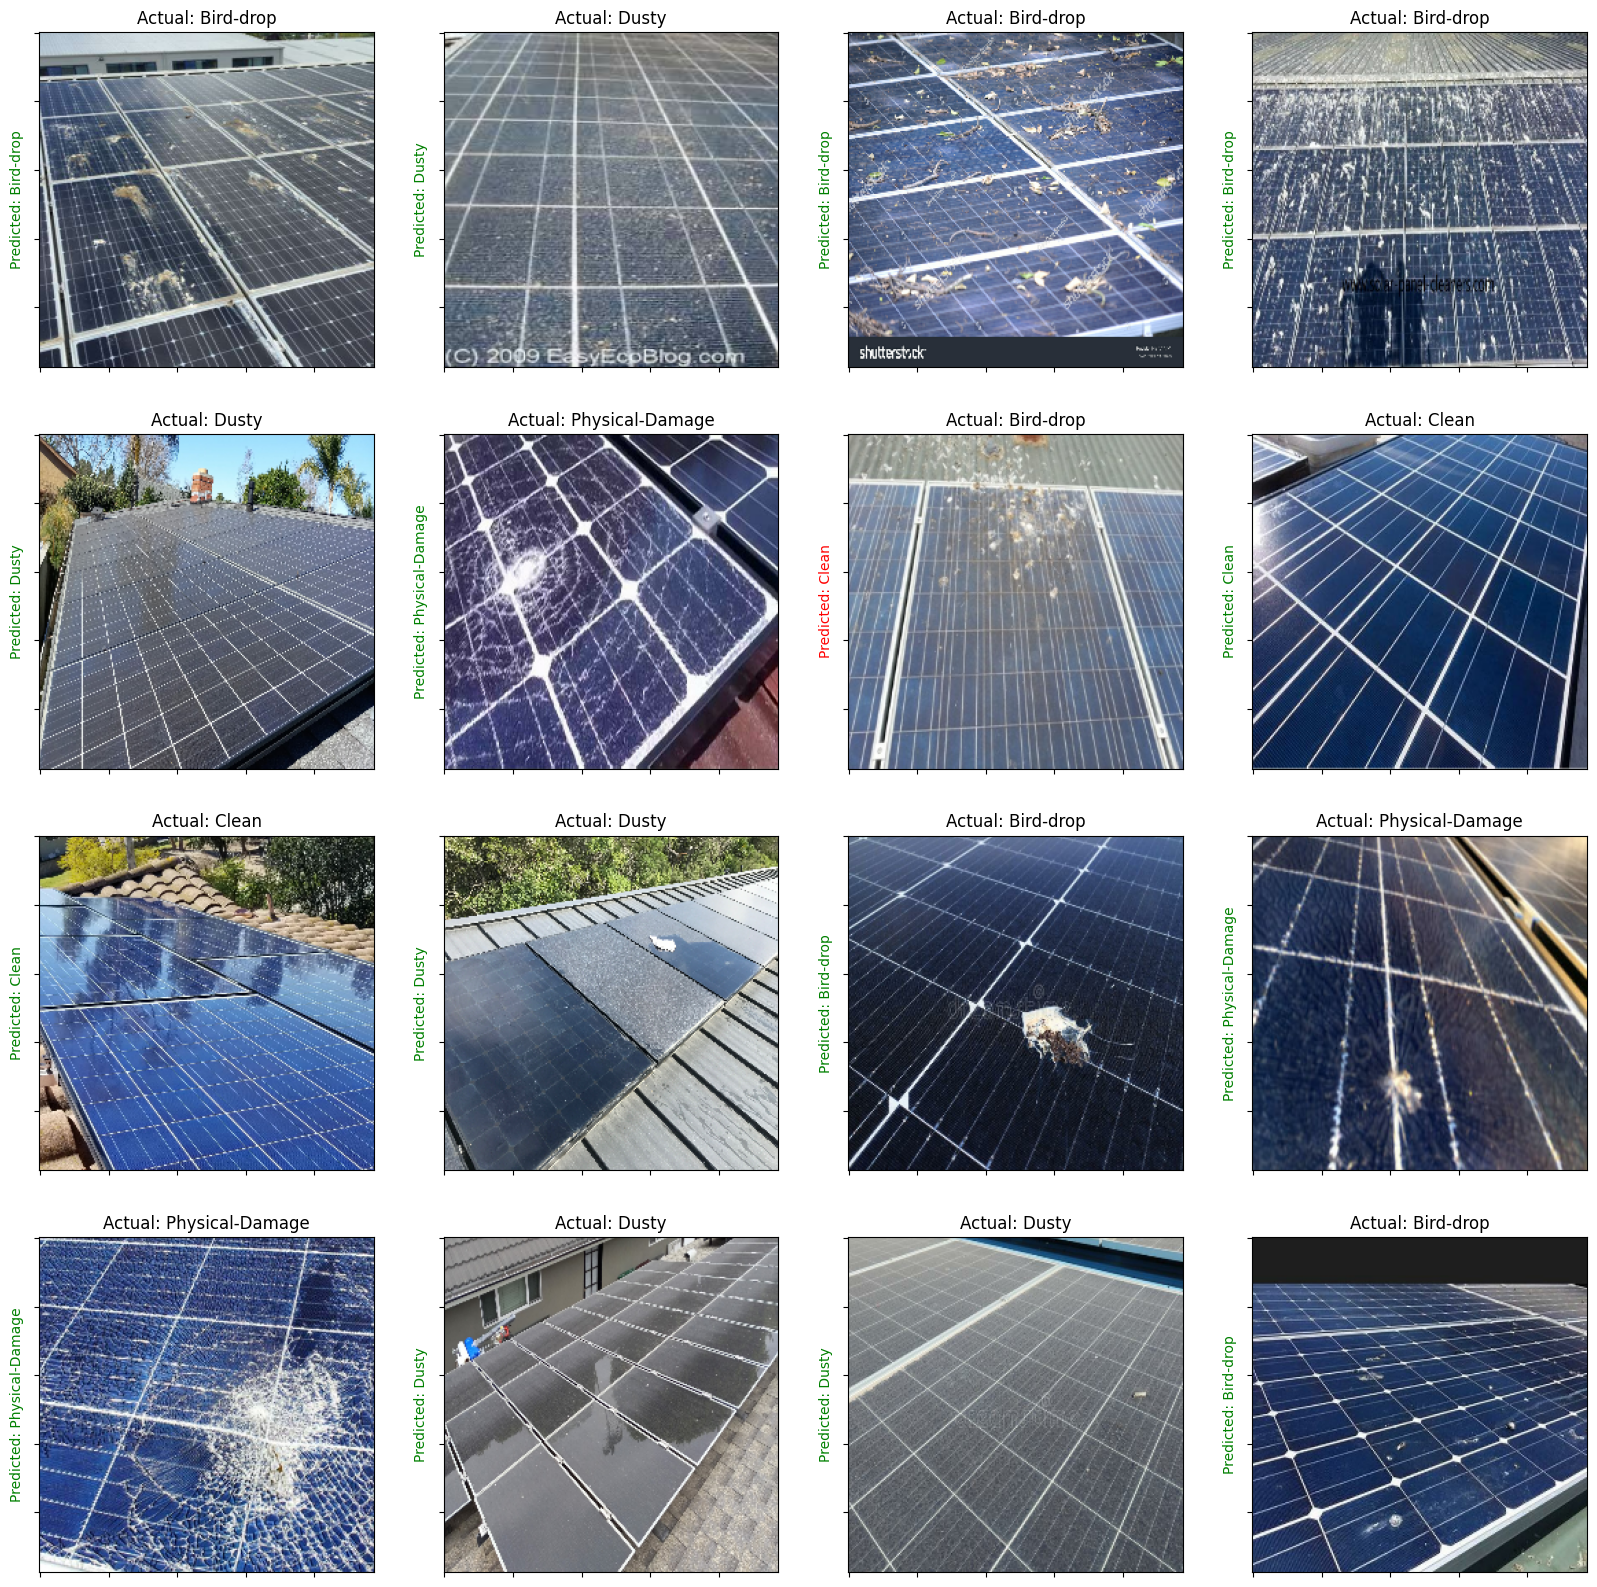

In [15]:
loss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

1/1 [==============================] - 3s 3s/step


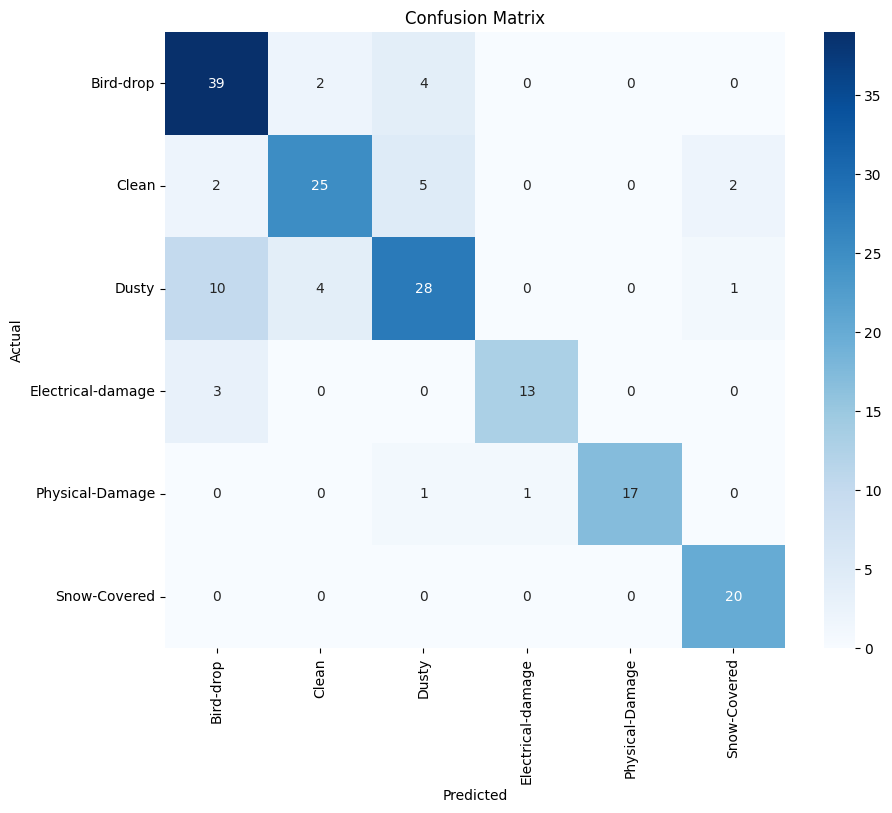

In [16]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.72      0.87      0.79        45
            Clean       0.81      0.74      0.77        34
            Dusty       0.74      0.65      0.69        43
Electrical-damage       0.93      0.81      0.87        16
  Physical-Damage       1.00      0.89      0.94        19
     Snow-Covered       0.87      1.00      0.93        20

         accuracy                           0.80       177
        macro avg       0.84      0.83      0.83       177
     weighted avg       0.81      0.80      0.80       177

